# Hate speech detection

The data is taken from the repository with the Dynamically Generated Hate Speech Dataset from Vidgen et al. (2021) https://github.com/bvidgen/Dynamically-Generated-Hate-Speech-Dataset.<br>
Reference paper https://aclanthology.org/2021.acl-long.132/

In [49]:
import numpy as np
import pandas as pd
import spacy
import re
from spacy.language import Language
from tqdm import tqdm

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

tqdm.pandas()

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

In [2]:
raw_file_name = "Dynamically Generated Hate Dataset v0.2.3.csv"
file_name = "Dynamically Generated Hate Dataset v0.2.3 clean.csv"

## Initial preprocessing

In [3]:
raw_df = pd.read_csv(raw_file_name).iloc[:, 1:]
raw_df.head()

,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched
0,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
1,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
2,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN
3,acl1000,4,I'm not saying we should actually eliminate heebs.. I just wish they naturally became extinct,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN
4,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN


In [4]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Custom component for cleaning text
@Language.component("clean_text")
def clean_text(doc):
    text = re.sub(r'http\S+', '', doc.text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)        # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and digits
    return nlp.make_doc(text)

# Custom component for normalizing text
@Language.component("normalize_text")
def normalize_text(doc):
    # Convert text to lowercase
    return nlp.make_doc(doc.text.lower())

# Custom component for lemmatizing text and removing stop-words
@Language.component("lemmatize_text")
def lemmatize_text(doc):
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return nlp.make_doc(lemmatized_text)

# Add the custom components to the spaCy pipeline
nlp.add_pipe("clean_text", first=True)
nlp.add_pipe("normalize_text", after="clean_text")
nlp.add_pipe("lemmatize_text", last=True)

<function __main__.lemmatize_text(doc)>

In [5]:
raw_df['clean_text'] = raw_df['text'].progress_apply(lambda x: nlp(x).text)

100%|███████████████████████████████████████████████████████████████████████████| 41144/41144 [04:51<00:00, 141.24it/s]


In [6]:
raw_df.to_csv(file_name, index=False, header=True)

## Wordcloud

In [37]:
df = pd.read_csv(file_name)
df = df.fillna({"clean_text": ""})
df["is_hate"] = df["label"].apply(lambda x: 1 if x == "hate" else 0)
df.head()

,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched,clean_text,is_hate
0,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN,dalit lowlive,1
1,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN,gay people burden society,1
2,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN,arab welcome,1
3,acl1000,4,I'm not saying we should actually eliminate heebs.. I just wish they naturally became extinct,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN,m say actually eliminate heebs wish naturally extinct,1
4,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN,banana black people,1


Let's draw a simple wordcloud for text which is considered as Hate and Not

In [33]:
normal_text = " ".join(df[df["label"] == "nothate"]["clean_text"])
hate_text = " ".join(df[df["label"] == "hate"]["clean_text"])

def get_wordcloud(text, title=""):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    fig = plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)

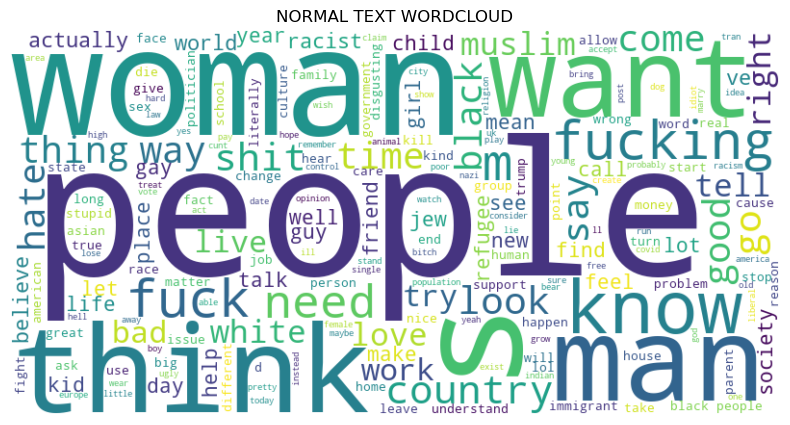

In [34]:
get_wordcloud(normal_text, "NORMAL TEXT WORDCLOUD")

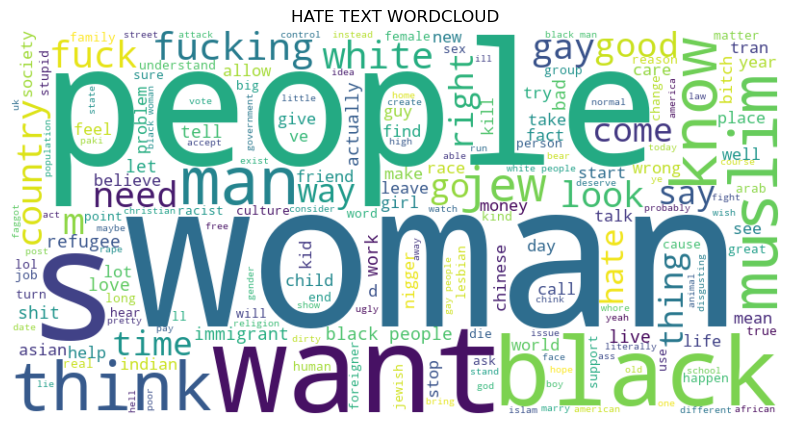

In [35]:
get_wordcloud(hate_text, "HATE TEXT WORDCLOUD")

## Simple TF-IDF

In [70]:
# Perform train-test split and text embedding with a simple TF-IDF
vectorizer = TfidfVectorizer()
y = df['is_hate']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(df["clean_text"], y, test_size=0.3, random_state=42)
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

In [46]:
# Tuning the inversed regularization strength of logistic regression
reg_params = np.logspace(-5, 3, 10)
train_acc, test_acc = [], []

for c in tqdm(reg_params):
    model = LogisticRegression(C=c, max_iter=1000)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.29it/s]


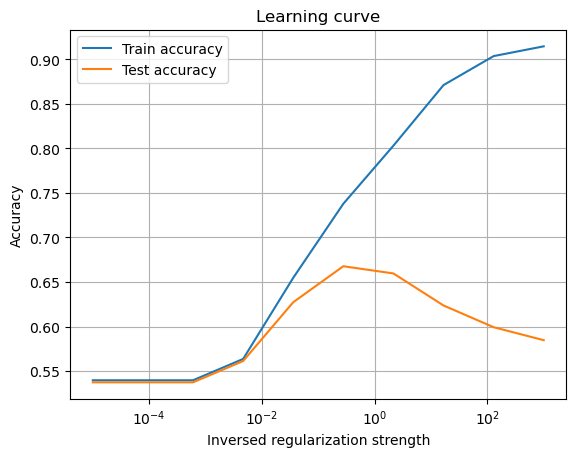

In [61]:
# Plot the learning curve
plt.grid()
ax = sns.lineplot(x=reg_params, y=train_acc, label="Train accuracy")
ax.set(xscale='log')
sns.lineplot(x=reg_params, y=test_acc, label="Test accuracy")
plt.xlabel("Inversed regularization strength")
plt.ylabel("Accuracy")
plt.title("Learning curve");

In [69]:
# Best model detailed analysis
best_lr = LogisticRegression(C=0.1)
best_lr.fit(X_train, y_train)

y_pred = best_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6604828256642904
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.51      0.58      5711
           1       0.65      0.79      0.72      6633

    accuracy                           0.66     12344
   macro avg       0.66      0.65      0.65     12344
weighted avg       0.66      0.66      0.65     12344

